In [1]:
import galarp as grp

from astropy import units as u

from gala import integrate as gi
from gala import dynamics as gd
from gala.units import galactic

from matplotlib import pyplot as plt

import numpy as np

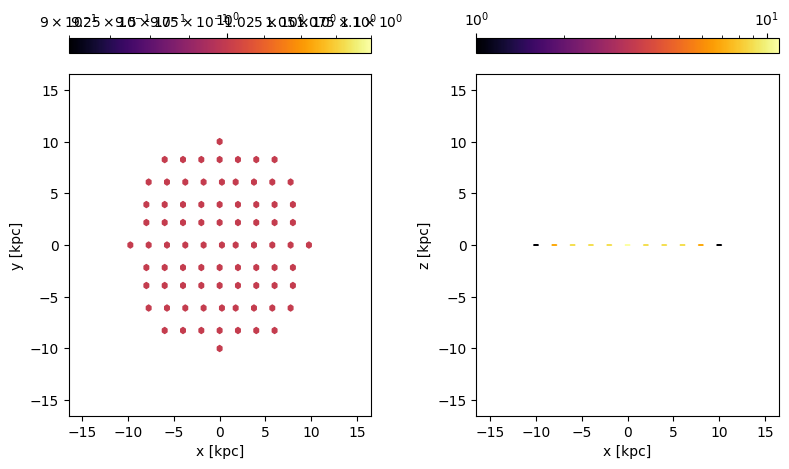

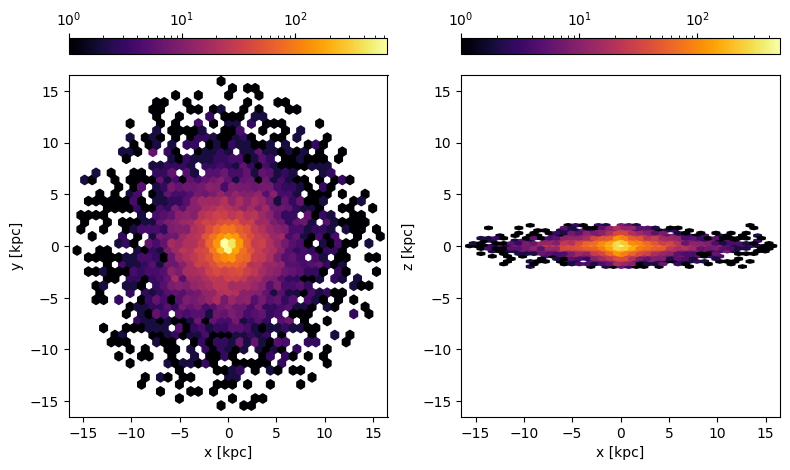

In [27]:

class ParticleDistribution:

    def __init__(self, units=galactic, **kwargs):
        self.x, self.y, self.z = [], [], []
        self.n_particles = 0
        self.units = units

    def generate(self, **kwargs):
        raise NotImplementedError("This method must be implemented in a subclass.")
    
    def save_positions(self, outname="positions.npy"):
        np.save(outname, np.array([self.x, self.y, self.z]))
    
    def plot_positions(self, **kwargs):
        grp.plot_density([self.x, self.y, self.z], **kwargs)

    def save(self, outname):
        grp.pickle_obj(self, outname)

    @staticmethod
    def from_file(filename, **kwargs):
        x, y, z = np.load(filename)

        pd = ParticleDistribution(gen_positions=False, **kwargs)
        pd.x, pd.y, pd.z = x, y, z
        pd.n_particles = len(x)

        return pd
    

class PlaneDistribution(ParticleDistribution):
    # Class to generate uniformly spaced particles in a plane

    def __init__(self, Rmax=10, zmax=10, spacing=1, gen_positions=True, **kwargs):
        super().__init__(**kwargs)

        self.Rmax = Rmax
        self.zmax = zmax
        self.spacing = spacing
        
        if gen_positions:
            self.generate()
    
    def generate(self, positions=None, velocity_dispersion=0):
        particle_range = np.arange(-self.Rmax, self.Rmax + self.spacing, self.spacing) * u.kpc
        for xi in particle_range:
            for yi in particle_range:
                R = np.sqrt(xi**2 + yi**2)
                if R > self.Rmax * u.kpc:
                    continue
                self.x.append(xi.to(self.units["length"]).value)
                self.y.append(yi.to(self.units["length"]).value)
                self.z.append(0.)


class ExponentialDistribution(ParticleDistribution):
    # Class to generate particles in an exponential disk

    def __init__(self, h_R=4, h_z=0.5, n_particles=100, gen_positions=True,  **kwargs):
        super().__init__(**kwargs)

        self.h_R = h_R
        self.h_z = h_z

        self.Rmax = kwargs.get("Rmax", 4 * self.h_R)
        self.zmax = kwargs.get("zmax", 4 * self.h_z)

        self.n_particles=n_particles

        self.n_0 = 1 / (4 * np.pi * h_R**2 * h_z)

        if gen_positions:
           self.generate()

    def generate(self, **kwargs):
        max_tries = kwargs.get("max_tries", 1000)
        for p_i in range(self.n_particles):
            good = False
            while not good:
                rand_R, rand_z = np.random.uniform(0, self.Rmax), np.random.uniform(-self.zmax, self.zmax)

                p = self.n_0 * np.exp(-rand_R / self.h_R) * np.exp(-np.abs(rand_z) / self.h_z)
                if np.random.random() <= p:
                    theta = np.random.uniform(0, 2 * np.pi)
                    self.x.append(rand_R * np.cos(theta))
                    self.y.append(rand_R * np.sin(theta))
                    self.z.append(rand_z)

                    good = True


class HernquistDistribution(ParticleDistribution):
    
    def __init__(self, R_s, n_particles=100, **kwargs):
        super().__init__(**kwargs)

        self.R_s = self.h_z = R_s
        self.Rmax = kwargs.get("Rmax", 4 * R_s)
        self.n_particles = n_particles

        self.n_0 = 1 / (2 * np.pi * R_s**3)

        self.generate()
    
    def generate(self, **kwargs):
        max_tries = kwargs.get("max_tries", 1000)
        for p_i in range(self.n_particles):
            good = False
            while not good:
                rand_R = np.random.uniform(0, self.Rmax)
                p = self.n_0 / ((rand_R / self.R_s) * (1 + rand_R / self.R_s)**3)

                if np.random.random() <= p:
                    phi, theta = np.random.uniform(0, 2 * np.pi), np.random.uniform(-np.pi, np.pi)

                    self.x.append(rand_R * np.sin(theta) * np.cos(phi))
                    self.y.append(rand_R * np.sin(theta) * np.sin(phi))
                    self.z.append(rand_R * np.cos(theta))

                    good = True

pd = PlaneDistribution(spacing=2)
pd.plot_positions(gridsize=40)
pd.save_positions("positions_uniform.npy")

ed = ExponentialDistribution(n_particles=10000, gen_positions=True)
ed.plot_positions(gridsize=40)
ed.save_positions("positions_exponential.npy")


In [3]:
pd_ff = PlaneDistribution.from_file("positions.npy")
ef_ff = ExponentialDistribution.from_file("positions_exponential.npy")

print(len(pd_ff.x), len(ed.x))

317 100


In [4]:
class ParticleSet:
    # Class to contain particle information (positions, masses, radii, etc)

    def __init__(self, particles=None, units=galactic, **kwargs):
        self.container = []

        self.masses = self.radii = self.sigmas = None

        self.particles = particles
        self.units = units

    def generate(self, mass_profile, velocity_dispersion=0 * u.km / u.s, **kwargs):
        """ Populate the container with particles given a mass profile.
            Velocity dispersion can be added.

        Args:
            mass_profile (_type_): _description_
            velocity_dispersion (_type_, optional): Velocity dispersion is created using a . Defaults to 0*u.km/u.s.
        """
        px, py, pz = self.particles.x, self.particles.y, self.particles.z
        assert len(px) == len(py) == len(pz)

        R = np.sqrt(px**2 + py**2) * self.units["length"]
        incs = np.arctan2(pz, R)

        theta = np.arctan2(py, px)

        for i in range(len(R)):
            vx, vy = grp.velocity(mass_profile, R[i], theta[i])[:2]
            vz = np.sqrt(vx ** 2 + vy ** 2) * np.sin(incs[i])

            p_v0 = [vx, vy, vz] * self.units["velocity"] + np.random.normal(scale=velocity_dispersion.value, size=3) * u.km / u.s

            w0 = gd.PhaseSpacePosition(pos=[px[i], py[i], pz[i]] * self.units["length"], vel=p_v0)
            
            self.container.append(w0)


pot = grp.builtins.JZ2023_Satellite()
mass_profile = grp.gen_mass_profile(pot)


pset = ParticleSet(particles=pd_ff)
pset.generate(mass_profile=mass_profile)    


/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [7]:
pset = grp.ParticleSet(particles=grp.PlaneDistribution(spacing=1))

pset.generate(mass_profile=mass_profile)



In [24]:
sim = grp.RPSim(wind=grp.builtins.RB2006_Wind(peak=10), potential=pot)
orbits = sim.run(particles=pset)




--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  0.79  degrees -------
------- Running for 500.0 Myr  at a timestep of  5.0 Myr  (100.0 steps) --------
--------------------------------------------------------------------------------
----------------------- Container contains 317 particles -----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------


100%|██████████| 99/99 [00:00<00:00, 761.56it/s]
